# Rupaul's Drag Race Machine

In [19]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import numpy as np
import math, random
from scipy.stats import rankdata, kendalltau
from sklearn.preprocessing import scale

theData = pd.read_csv("dragrace9.csv")
theData= theData.fillna(0)
#theData.iloc[1:10,:]

In [20]:
queens = theData
queens.shape

(115, 21)

In [21]:
# create a function to scale the data for us
def scaleQueens(df):
    """Scale Age, Wins, Highs, Lows, and Lipsyncs in feature data frames"""
    df = df.copy(deep=True)
    df['Age'] = scale(df['Age'])
    df['Wins'] = scale(df['Wins'])
    df['Highs'] = scale(df['Highs'])
    df['Lows'] = scale(df['Lows'])
    df['Lipsyncs'] = scale(df['Lipsyncs'])
    df['Season'] = df['Season']/9
    return df

In [22]:
def compareRanks(x,y):
    """x = actual, y = predicted place"""
    x=np.asarray(x)
    y=np.asarray(y)
    numRanks = np.append(x,y).max()
    actual=np.sum(np.square(x-y))
    worst=np.sum(np.square(np.sort(x)-np.sort(x)[::-1]))
    return 1-2*(actual/worst)

In [23]:
def rankScore(model,x,y):
    ypred = model.predict(x)
    score = compareRanks(y,ypred)
    return score

In [24]:
def createPD(s,queens,yfitpd):
    season = queens.loc[queens.Season==s,['Name','Place']]
    seasonpred = yfitpd.loc[queens.Season==s]
    season['Predicted'] = seasonpred
    season['Predicted'] = rankdata(season.Predicted,method='min')
    season = season.sort_values('Place')
    return season

In [25]:
def predictSeason(season,model,queens,scaled=False):
    Xtrain = queens.loc[queens.Season!=season,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season']]
    Xtest = queens.loc[queens.Season==season,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season']]
    ytrain = queens.loc[queens.Season!=season,'Place']
    if scaled:
        Xtrain = scaleQueens(Xtrain)
        Xtest = scaleQueens(Xtest)
    model.fit(Xtrain,ytrain)
    yfit = model.predict(Xtest)
    pddf = queens.loc[queens.Season==season,['Name','Place']]
    pddf['Predicted'] = rankdata(yfit,method='min')
    return pddf

In [26]:

class neural_network:
    """Defines a neural network, along with attributes for fitting and predicting the network"""
    def __init__(self,size):
        random.seed(0)
        self.network = []
        for i in range(1,len(size)):
            self.network.append([[random.random() for __ in range(size[i-1] + 1)] for __ in range(size[i])])
    
    def sigmoid(self,t): 
        return 1 / (1 + math.exp(-t))
    
    def neuron_output(self,weights, inputs):   #This is a simpler representation; weights for input plus one extra (bias)
        return self.sigmoid(np.dot(weights, inputs))
    
    def feed_forward(self,input_vector):
        outputs = []

        for layer in self.network: #Remember the neural network is given as a list of "layers" which have neurons in them

            input_with_bias = input_vector + [1]          # add a bias input (this just allos us to use a dot product)
            output = [self.neuron_output(neuron, input_with_bias) # compute the output
                      for neuron in layer]                   # for this layer
            outputs.append(output)                           # and remember it

            # the input to the next layer is the output of this one
            input_vector = output

        return outputs
    
    def predict(self,X):
        X = scaleQueens(X)
        predictedY = []
        X = X.values.tolist()
        for i, input in enumerate(X):
            outputs = self.feed_forward(input)[-1]
            predictedY.append(outputs)
        predictedPlace = [a.index(max(a)) for a in predictedY]
        return predictedPlace
    
    
    def convertY(self,Y):
        yNN = [[1 if i == (j-1) else 0 for i in range(0,len(Y)-1)]
               for j in Y ]
        return(yNN)
    
    # define the back-propagation that allows the network to learn
    def backpropagate(self, input_vector, target):
        hidden_outputs, outputs = self.feed_forward(input_vector)

        # the output * (1 - output) is from the derivative of sigmoid
        output_deltas = [output * (1 - output) * (output - target[i])
                         for i, output in enumerate(outputs)]

        # adjust weights for output layer (network[-1])
        for i, output_neuron in enumerate(self.network[-1]):
            for j, hidden_output in enumerate(hidden_outputs + [1]):
                output_neuron[j] -= output_deltas[i] * hidden_output

        # back-propagate errors to hidden layer
        hidden_deltas = [hidden_output * (1 - hidden_output) * 
                          np.dot(output_deltas, [n[i] for n in self.network[-1]]) 
                         for i, hidden_output in enumerate(hidden_outputs)]

        # adjust weights for hidden layer (network[0])
        for i, hidden_neuron in enumerate(self.network[0]):
            for j, input in enumerate(input_vector + [1]):
                hidden_neuron[j] -= hidden_deltas[i] * input
    
    def fit(self,features,targets,times=10000):
        features = scaleQueens(features)
        targets = self.convertY(targets)
        features = features.values.tolist()
        for i in range(times):
            for X, Y in zip(features, targets):
                self.backpropagate(X,Y)
        
        
        

In [27]:
def setXY(x,y,n):
    """Get appropriate x,y coords in cases of ties"""
    y = y - int((n-1)/3)*0.8
    if n % 3 == 2:
        x = x - 0.33
    elif n % 3 == 0:
        x = x + 0.33
    return(x,y)

Initialize the models

In [28]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier

svc_model = SVC(kernel='rbf',gamma=0.01,C=10)
gnb_model = GaussianNB()
rfc_model = RandomForestClassifier(n_estimators=100, random_state=0)
rfr_model = RandomForestRegressor(200,random_state=24601)
nn2_model=MLPClassifier(hidden_layer_sizes=(5,),
                       activation='logistic',
                       solver='lbfgs',
                       random_state=24601)

Have each model predict the rankings and save to a data frame


In [29]:
predictSeason(9,nn2_model,queens,True)

/Users/thomas/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


,Name,Place,Predicted
101,Aja,0.0,10
102,Alexis Michelle,0.0,10
103,Charlie Hides,0.0,3
104,Eureka,0.0,4
105,Farrah Moan,0.0,10
106,Jaymes Mansfield,14.0,7
107,Kimora Blac,0.0,7
108,Nina Bo'Nina Brown,0.0,1
109,Peppermint,0.0,14
110,Sasha Velour,0.0,5


In [30]:
the_models = [gnb_model,rfc_model,rfr_model,nn2_model]
model_names = ["GNB","RFC","RFR","NN"]
season = predictSeason(9,svc_model,queens,True)
season['Season'] = 9
season['Model'] = 'SVC'
rank_score = compareRanks(season.Place,season.Predicted)
rsdf = pd.DataFrame({'Season': [9], 'Value': [rank_score], 'Model': ['SVM']})
pred_df = season
rank_scores = rsdf.copy(deep=True)
n = 0
for model in the_models:
    season = predictSeason(9,model,queens,True)
    season['Season'] = 9
    season['Model'] = model_names[n]
    pred_df = pred_df.append(season)
    rank_score = compareRanks(season.Place,season.Predicted)
    rsdf = pd.DataFrame({'Season': [9], 'Value': [rank_score], 'Model': [model_names[n]]})
    rank_scores = rank_scores.append(rsdf)
    n += 1


/Users/thomas/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
/Users/thomas/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
/Users/thomas/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [31]:
resultsTable = pred_df.pivot_table(index=('Name','Place','Season'),columns='Model').sortlevel(['Season','Place'])
resultsTable = resultsTable.reset_index()
resultsTable['mean'] = resultsTable.Predicted.mean(axis=1)
resultsTable['PredPlace'] = rankdata(resultsTable['mean'],method='min')
resultsTable.to_csv('PredictedSeason9.csv')
resultsTable.sort_values(by='mean')

Name Place Season Predicted                  mean  \
Model                                          GNB  NN RFC RFR SVC         
8        Nina Bo'Nina Brown   0.0      9         1   1   1   1   1   1.0   
13                Valentina   0.0      9         1   1   6   2   1   2.2   
12           Trinity Taylor   0.0      9         1   7   2   3   3   3.2   
10             Sasha Velour   0.0      9         1   5   2   4  12   4.8   
11              Shea Coulee   0.0      9         1   5  10   5  12   6.6   
7               Kimora Blac   0.0      9        12   7   4   8   5   7.2   
5               Farrah Moan   0.0      9         1  10   7  11   8   7.4   
6          Jaymes Mansfield  14.0      9        13   7   5   7   5   7.4   
0                       Aja   0.0      9         1  10   7  12   8   7.6   
2             Charlie Hides   0.0      9        10   3  14   9   3   7.8   
4                    Eureka   0.0      9        13   4  10   6   7   8.0   
1           Alexis Michelle   0.0      9         1  10  10  13   8   8.4   
3      Cynthia Lee Fontaine   0.0      9        11  10   7  10   8   9.2   
9                Peppermint   0.0      9         1  14  10  14  12  10.2   

      PredPlace  
Model            
8             1  
13            2  
12            3  
10            4  
11            5  
7             6  
5             7  
6             7  
0             9  
2            10  
4            11  
1            12  
3            13  
9            14

In [32]:
rank_scores

,Model,Season,Value
0,SVM,9,-3.403061
0,GNB,9,-1.775510
0,RFC,9,-3.515306
0,RFR,9,-4.178571
0,NN,9,-3.183673


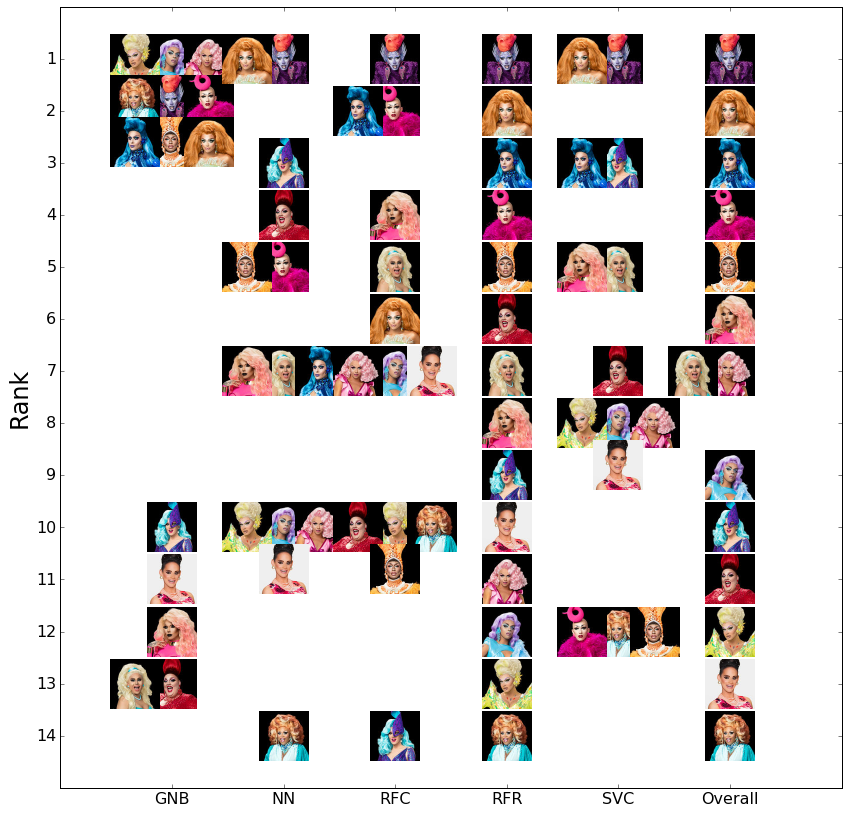

In [33]:
# don't forget to change this to add a fourteenth place next week

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(1,1,1)
plt.xticks(range(6), ['GNB','NN','RFC','RFR','SVC','Overall'], size='small')
plt.yticks(range(14),range(14,0,-1))
ax.set_ylim([-1,14])
ax.set_xlim([-1,6])
ax.set_ylabel("Rank",fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=16)

models = ['GNB','NN','RFC','RFR','SVC']

for i in range(5):
    the_data = pred_df.loc[pred_df.Model==models[i],:]
    places = {}
    for name in the_data.Name:
        file_name = name.replace(" ","").replace("'","") + "Mug.jpg"
        place = 14-np.asscalar(the_data.loc[the_data.Name==name,'Predicted'])
        if place in places.keys():
            places[place]+=1
        else:
            places[place]=1
        img = mpimg.imread("Season 9 Queens/"+file_name)
        im = OffsetImage(img,zoom=0.5)
        x, y = setXY(i,place,places[place])
        ab = AnnotationBbox(im,(x,y),xycoords='data',frameon=False)
        ax.add_artist(ab)

the_data = resultsTable
places = {}
for name in the_data.Name:
    file_name = name.replace(" ","").replace("'","") + "Mug.jpg"
    place = 14-np.asscalar(the_data.loc[the_data.Name==name,'PredPlace'])
    if place in places.keys():
        places[place]+=1
    else:
        places[place]=1
    img = mpimg.imread("Season 9 Queens/"+file_name)
    im = OffsetImage(img,zoom=0.5)
    x, y = setXY(5,place,places[place])
    ab = AnnotationBbox(im,(x,y),xycoords='data',frameon=False)
    ax.add_artist(ab)
    

#img = mpimg.imread("Season 9 Queens/AjaMug.jpg")
#im = OffsetImage(img,zoom=0.5)
#x = 1; y = 0.6
#ab = AnnotationBbox(im, (x,y), xycoords='data', frameon=False)
#ax.add_artist(ab)
fig.savefig("predicted9.png")

# Based on Princess Points

A group of drag race super fans scored the meet the queens videos for season 8, and then again for season 9. The results below train on season 8 only and then predict season 9.

In [34]:
def predictSeasonPrincess(season,model,queens,scaled=False):
    Xtrain = queens.loc[queens.Season==8,['Age','PuertoRico','PlusSize','Season',
                                          'Party Princess','Purity Princess','Draggity Princess','Blackout Princess',
                                         'Cookie Princess','Bartender Princess']]
    Xtest = queens.loc[queens.Season==9,['Age','PuertoRico','PlusSize','Season',
                                          'Party Princess','Purity Princess','Draggity Princess','Blackout Princess',
                                         'Cookie Princess','Bartender Princess']]
    ytrain = queens.loc[queens.Season==8,'Place']
    if scaled:
        Xtrain = scaleQueensPrincess(Xtrain)
        Xtest = scaleQueensPrincess(Xtest)
    model.fit(Xtrain,ytrain)
    yfit = model.predict(Xtest)
    pddf = queens.loc[queens.Season==9,['Name','Place']]
    pddf['Predicted'] = rankdata(yfit,method='min')
    return pddf

In [35]:
# create a function to scale the data for us
def scaleQueensPrincess(df):
    """Scale Age, Wins, Highs, Lows, and Lipsyncs in feature data frames"""
    df = df.copy(deep=True)
    df['Age'] = scale(df['Age'])
    for princess in ['Party Princess','Purity Princess','Draggity Princess',
                     'Blackout Princess','Cookie Princess','Bartender Princess']:
        df[princess] = scale(df[princess])
    df['Season'] = df['Season']/9
    return df

In [36]:
the_models = [gnb_model,rfc_model,rfr_model,nn2_model]
model_names = ["GNB","RFC","RFR","NN"]
season = predictSeasonPrincess(9,svc_model,queens,True)
season['Season'] = 9
season['Model'] = 'SVC'
rank_score = compareRanks(season.Place,season.Predicted)
rsdf = pd.DataFrame({'Season': [9], 'Value': [rank_score], 'Model': ['SVM']})
pred_df = season
rank_scores = rsdf.copy(deep=True)
n = 0
for model in the_models:
    if model_names[n] == "GNB" or model_names[n] == "NN":
        season = predictSeasonPrincess(9,model,queens,True)
    else:
        season = predictSeasonPrincess(9,model,queens,False)
    season['Season'] = 9
    season['Model'] = model_names[n]
    pred_df = pred_df.append(season)
    rank_score = compareRanks(season.Place,season.Predicted)
    rsdf = pd.DataFrame({'Season': [9], 'Value': [rank_score], 'Model': [model_names[n]]})
    rank_scores = rank_scores.append(rsdf)
    n += 1

/Users/thomas/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
/Users/thomas/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [37]:
resultsTable = pred_df.pivot_table(index=('Name','Place','Season'),columns='Model').sortlevel(['Season','Place'])
resultsTable = resultsTable.reset_index()
resultsTable['Mean'] = resultsTable.mean(axis=1)
resultsTable['PredPlace'] = rankdata(resultsTable['Mean'],method='min')
resultsTable = resultsTable.sort_values(by='PredPlace')
resultsTable.to_csv("princessPredictions9.csv")
resultsTable

Name Place Season Predicted                     Mean  \
Model                                          GNB NN RFC RFR SVC             
2             Charlie Hides   0.0      9         5  1   1   7   1  3.428571   
4                    Eureka   0.0      9         5  6   2   5   3  4.285714   
9                Peppermint   0.0      9         2  3   8   8   3  4.714286   
12           Trinity Taylor   0.0      9         1  6   4  12   2  4.857143   
1           Alexis Michelle   0.0      9         2  3   8  10   3  5.000000   
5               Farrah Moan   0.0      9         5  9   5   2   7  5.285714   
13                Valentina   0.0      9         5  9   5   3   7  5.428571   
6          Jaymes Mansfield  14.0      9         5  1   2   1   7  5.571429   
11              Shea Coulee   0.0      9         5  9   5   4   7  5.571429   
7               Kimora Blac   0.0      9         5  5  11   6   7  6.142857   
3      Cynthia Lee Fontaine   0.0      9         4  6  10  14   6  7.000000   
0                       Aja   0.0      9         5  9  11   9   7  7.142857   
10             Sasha Velour   0.0      9         5  9  11  11   7  7.428571   
8        Nina Bo'Nina Brown   0.0      9         5  9  11  13   7  7.714286   

      PredPlace  
Model            
2             1  
4             2  
9             3  
12            4  
1             5  
5             6  
13            7  
6             8  
11            8  
7            10  
3            11  
0            12  
10           13  
8            14

# Visuals

In [38]:
x,y = setXY(1,3,2)
print(x)
print(y)

0.6699999999999999
3.0


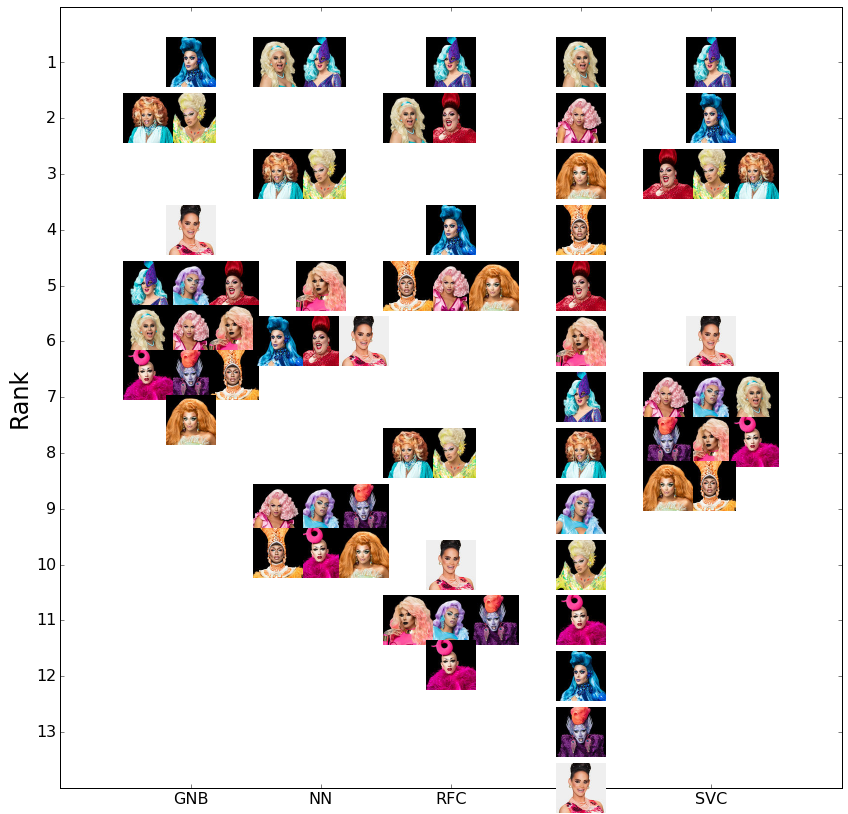

In [39]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(1,1,1)
plt.xticks(range(5), ['GNB','NN','RFC','RFR','SVC'], size='small')
plt.yticks(range(13),range(13,0,-1))
ax.set_ylim([-1,13])
ax.set_xlim([-1,5])
ax.set_ylabel("Rank",fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=16)

models = ['GNB','NN','RFC','RFR','SVC']

for i in range(5):
    the_data = pred_df.loc[pred_df.Model==models[i],:]
    places = {}
    for name in the_data.Name:
        file_name = name.replace(" ","").replace("'","") + "Mug.jpg"
        place = 13-np.asscalar(the_data.loc[the_data.Name==name,'Predicted'])
        if place in places.keys():
            places[place]+=1
        else:
            places[place]=1
        img = mpimg.imread("Season 9 Queens/"+file_name)
        im = OffsetImage(img,zoom=0.5)
        x, y = setXY(i,place,places[place])
        ab = AnnotationBbox(im,(x,y),xycoords='data',frameon=False)
        ax.add_artist(ab)
        
    

#img = mpimg.imread("Season 9 Queens/AjaMug.jpg")
#im = OffsetImage(img,zoom=0.5)
#x = 1; y = 0.6
#ab = AnnotationBbox(im, (x,y), xycoords='data', frameon=False)
#ax.add_artist(ab)
fig.savefig("predicted9princess.png")

# Comparing Neural Networks

In [40]:
nn_sigmoid = MLPClassifier(hidden_layer_sizes=(5,),
                       activation='logistic',
                       solver='lbfgs',
                       random_state=24601)
nn_relu = MLPClassifier(hidden_layer_sizes=(5,),
                       activation='relu',
                       solver='lbfgs',
                       random_state=24601)
nn_tanh = MLPClassifier(hidden_layer_sizes=(5,),
                       activation='tanh',
                       solver='lbfgs',
                       random_state=24601)

In [41]:
from sklearn.model_selection import train_test_split

X = queens.loc[queens.Season!=9,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season']]
Y = queens.loc[queens.Season!=9,'Place']

train = queens.loc[queens.Season<8,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season','Place']]
test = queens.loc[queens.Season==8,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season','Place']]

Xtrain = train.loc[train.Season<8,:]
Xtrain.drop('Place',axis=1,inplace=True)
Xtest = test.loc[test.Season==8,:]
Xtest.drop('Place',axis=1,inplace=True)
ytrain = train.loc[train.Season<8,'Place']
ytest = test.loc[test.Season==8,'Place']

# Xtrain, Xtest, ytrain, ytest = train_test_split(X,Y,random_state=78)

In [42]:
Xtrain = scaleQueens(Xtrain)
Xtest = scaleQueens(Xtest)

/Users/thomas/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [43]:
Xtrain.shape

(89, 8)

In [44]:
Xtest.shape

(12, 8)

In [45]:
ytest.shape

(12,)

In [46]:
ytrain.shape

(89,)

## sigmoid

In [47]:
nn_sigmoid.fit(Xtrain,ytrain)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=24601,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [48]:
rankScore(nn_sigmoid,Xtest,ytest)

0.77735849056603779

## ReLU

In [49]:
nn_relu.fit(Xtrain,ytrain)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=24601,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [50]:
rankScore(nn_relu,Xtest,ytest)

0.76226415094339628

## Tanh

In [51]:
nn_tanh.fit(Xtrain,ytrain)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=24601,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [52]:
rankScore(nn_tanh,Xtest,ytest)

0.72452830188679251